height interval
(2.7208096461944256, 5.311176482325653)
height_anomalies [5.4556240232076245, 5.982665629871498, 5.692800312644468, 5.720203710156177, 2.4181570661148473, 2.1612516598367395, 2.107616527550905, 2.405009422297603]

width interval
(31.887598319182153, 135.11240168081784)
width_anomalies [141, 138, 138, 148, 22, 3, 5]

height interval
(4.971775218435404, 5.620006966475762)
height_anomalies [4.756850366979955, 4.83376172508109, 4.912632398960942, 4.804666299552693, 5.656690115146764, 5.995353578134566, 5.72346328952207, 5.873906711445034]

width interval
(129.84478776200518, 190.15521223799482)
width_anomalies [98, 126, 209, 198, 196, 127, 207]

height interval
(4.754559177621256, 5.11184670537327)
height_anomalies [4.627663322603768, 4.731408190442343, 5.148696937995789, 5.170434984028258, 4.568918641419801, 5.349821325518198, 4.651178266941056, 4.7511062432662765, 5.349038468752167]

width interval
(128.64575985063618, 185.62090681603047)
width_anomalies [246, 206, 109, 1

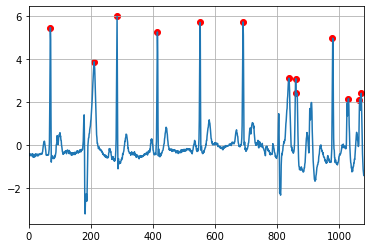

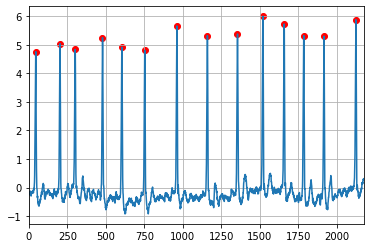

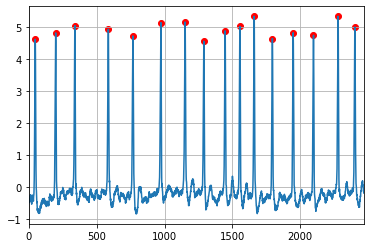

In [11]:
import scipy.io
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import scipy.stats as st
from sklearn.decomposition import FastICA

def load_data(file):
    mat = scipy.io.loadmat(file)
    return mat['val'][0]

def show_single_plot(y_beat, spike_times, spike_vals):
    fig_subset_view, ax = plt.subplots()
    ax.scatter(spike_times, spike_vals, color='red')
    ax.grid()
    show_multiplot(ax, y_beat)

def show_multiplot(ax, y):
    x_linspace = np.linspace(0, len(y), len(y))
    ax.set_xlim([0, len(y)])
    ax.plot(x_linspace, y)


def apply_filter(y_transformed, strength):
    filtered_y = np.array([])
    for row in y_transformed.T:
        
        filtered_row = savgol_filter(row, strength, 1)
        filtered_row = filtered_row.T
        filtered_y = np.append(filtered_y, filtered_row)
        filtered_y = np.reshape(filtered_y, (-1, 1500))
    return filtered_y.T

def filter_noise(filename):
    mat = scipy.io.loadmat('heartbeat_data/'+filename)
    y=mat['val'][0]
    y_transposed = y.T # columns
    transformer = FastICA(whiten='unit-variance')
    y_transformed = transformer.fit_transform(y_transposed)
    y_beats = []

    for row in y_transformed.T:
        if min(row)< -2 or max(row)>2:
            # flip sign
            if abs(np.min(row)) > abs(np.max(row)):
                row = row * -1
            y_beats.append(row)

    y_beats = np.asarray(y_beats)
    # fig_subset_view, ax = plt.subplots()
    # ax.grid()
    # show_multiplot(ax, y_beats.T)
    return y_beats


def filter_fetus(y_beats):
    sum_first_beats = sum(scipy.signal.find_peaks(y_beats[0], height=2)[0])
    sum_second_beats = sum(scipy.signal.find_peaks(y_beats[1], height=2)[0])
    return  y_beats[0] if sum_first_beats > sum_second_beats else y_beats[1]

def better_anomalies_detection(data, cofidence):
    interval = st.t.interval(confidence= cofidence, df=len(data)-1,
              loc=np.mean(data),
              scale=st.sem(data))
    print(interval)
    #dists[(np.where((dists >= r) & (dists <= r + dr)))]
    outliers = []
    for point in data:
        if point < interval[0] or point > interval[1]:
            outliers.append(point)
    return outliers

def find_anomalies(data):
    #define a list to accumlate anomalies
    anomalies = []
    
    # Set upper and lower limit to 3 standard deviation
    data_std = np.std(data)
    data_mean = np.mean(data)
    print(data_mean)
    cuttoff=1 # 68% -1 , 95% -2 , 99.7% -3
    anomaly_cut_off = data_std * cuttoff
    
    lower_limit  = data_mean - anomaly_cut_off 
    upper_limit = data_mean + anomaly_cut_off
    
    # Generate outliers
    for outlier in data:
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(outlier)
    
    return anomalies

def main():
    start = 25
    stop = 28  #set the number of files you want to go through
    for i, filename in enumerate(os.listdir('heartbeat_data')):
        out = re.findall(r'\d+', filename)
        if int(out[0]) < start:
            continue
        if i == stop:
            break
        y_beats = filter_noise(filename)
        y_beat = filter_fetus(y_beats)


        peaks = scipy.signal.find_peaks(y_beat, height=2)
        spike_times= peaks[0]
        spike_vals = peaks[1]['peak_heights']

        # height is not a good indicator for confidence intervals
        print('height interval')
        height_anomalies = better_anomalies_detection(spike_vals, 0.99)
        print('height_anomalies', height_anomalies)
        print('')
        # peak width diff is not a good indicator for confidence intervals

        # collect this
        peak_width_diff=[np.abs(spike_times[i]-spike_times[i+1]) for i in range(len(spike_times)-1)]

        # print('peak_width_diff', peak_width_diff)
        print('width interval')
        width_anomalies = better_anomalies_detection(peak_width_diff, 0.99)
        print('width_anomalies', width_anomalies)
        print('')
        show_single_plot(y_beat, spike_times, spike_vals)
        # print('heights',spike_vals)
        # print(spike_times)
main()
